## Прогноз количества заказов такси

Агрегатор такси в Чикаго хочет прогнозировать количество заказов в каждом районе. 
Это необходимо, чтобы в моменты пиковой нагрузки привлекать больше водителей, а во время спада оотправлять их в другие места. 
Для обучения модели машинного обучения предоставлены данные о 10 млн заказов такси за 2022 и 2023 год.
Информацию собирает регулирующий орган. Из соображений конфиденциальности, идентификатор такси соответствует заданному номеру медальона такси, переписные участки в некоторых случаях скрыты, а время округляется до ближайших 15 минут.

Метриками качества приняты МАЕ и MAPE.

По условиям проекта, необходимо развернуть локальные контейнеры через Docker и произвести большую часть работ в PySpark.

# Этап 1: Обработка и исследование данных, выделение целевого показателя

### Импортируем библиотеки, загрузим данные, посмотрим их состав

In [1]:
pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/7e/da/408e50ad8ce7dbca81d126377e57897784025647b719534f3529c4b71a9c/prophet-1.1.4-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 153.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 584.6 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for holidays>=0.25 from https://files.pythonhosted.org/packages/0e/6d/8a673d26d687486aac3b2b77faaa9fe5f452cadc2fc586081ddeda3b5140/holidays-0.33-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 1.3 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.1 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 977.8 kB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.7/759.7 kB 296.4 kB/

In [2]:
pip install --upgrade plotly

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/df/79/c80174d711ee26ee5da55a9cc3e248f1ec7a0188b5e4d6bbbbcd09b974b0/plotly-5.17.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/f4/f1/990741d5bb2487d529d20a433210ffa136a367751e454214013b441c4575/tenacity-8.2.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 1.1 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tracemalloc

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [4]:
SPARK_MASTER_IP = '172.18.0.2' 
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .config("spark.executor.cores", 2) \
    .config('spark.local.dir', 'spark_tmp/') \
    .config("spark.task.cpus", 2) \
    .getOrCreate()

In [5]:
spark

In [6]:
dfsp22 = spark.read.csv("Taxi_Trips_-_2022.csv", header = True, inferSchema = True)
dfsp22.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area| Fare|Tips|Tolls|Extras|Trip Total|Payment Type|             Company|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid  Location|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+--------

In [7]:
dfsp23 = spark.read.csv("Taxi_Trips_-_2023.csv", header = True, inferSchema = True)
lim23 = '2023-07-31 23:00'
dfsp23 = dfsp23.filter(F.to_timestamp(F.col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a')<lim23)
dfsp23.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area| Fare|Tips|Tolls|Extras|Trip Total|Payment Type|             Company|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid  Location|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+--------

    В последнем часе наблюдений 2023-08-01 00:00 поездок мало, заказчик просил его не учитывать.

    в качестве тестового берем 2023-07-31 23:00, поэтому сразу отрежем все наблюдения по нему.

In [8]:
print(type(dfsp22))
dfsp22.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: doubl

## Объединим данные, обработаем дубликаты, пропуски, выбросы

In [9]:
if dfsp22.columns != dfsp23.columns:
    print('разная структура')
else:
    dfsp = dfsp22.union(dfsp23).cache()
    print('Данные за 2022 и 2023 годы успешно объединены')


Данные за 2022 и 2023 годы успешно объединены


#проверим на дубликаты
df = dfsp.dropDuplicates(dfsp.columns)
if df.count() == dfsp.count():
    print('как и заявлено в описании данных, полных дубликатов нет')

else: 
    print('Полных дубликатов', dfsp.dropDuplicates(dfsp.columns))


In [10]:
dfsp.dropDuplicates(dfsp.columns).count()

10165684

In [11]:
#переименуем колонки в df
for col in dfsp.columns:
    dfsp = dfsp.withColumnRenamed(col, col.lower().replace(' ', '_'))
print(dfsp.columns)

['trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'pickup_centroid_location', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'dropoff_centroid__location']


In [12]:
tracemalloc.start()
def mem_use():
    mem_size, mem_peak = tracemalloc.get_traced_memory()
    print(f'Количество используемой памяти {mem_size:_} байт, '
          f'пиковое {mem_peak:_} байт')

mem_use()

Количество используемой памяти 1_488 байт, пиковое 14_432 байт


In [13]:
dfsp.show(5, truncate = 30)
dfsp.count()

+------------------------------+------------------------------+----------------------+----------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------------+-------------------------+--------------------------+------------------------------+
|                       trip_id|                       taxi_id|  trip_start_timestamp|    trip_end_timestamp|trip_seconds|trip_miles|pickup_census_tract|dropoff_census_tract|pickup_community_area|dropoff_community_area| fare|tips|tolls|extras|trip_total|payment_type|             company|pickup_centroid_latitude|pickup_centroid_longitude|      pickup_centroid_location|dropoff_centroid_latitude|dropoff_centroid_longitude|    dropoff_centroid__location|
+------------------------------+------------------------------+----------------------+----

10165684

In [14]:
dfsp.select('pickup_community_area').distinct().sort(dfsp.pickup_community_area.asc()).show(80)
dfsp.select('pickup_community_area').distinct().count()

+---------------------+
|pickup_community_area|
+---------------------+
|                 null|
|                    1|
|                    2|
|                    3|
|                    4|
|                    5|
|                    6|
|                    7|
|                    8|
|                    9|
|                   10|
|                   11|
|                   12|
|                   13|
|                   14|
|                   15|
|                   16|
|                   17|
|                   18|
|                   19|
|                   20|
|                   21|
|                   22|
|                   23|
|                   24|
|                   25|
|                   26|
|                   27|
|                   28|
|                   29|
|                   30|
|                   31|
|                   32|
|                   33|
|                   34|
|                   35|
|                   36|
|                   37|
|               

78

In [15]:
# Посчитаем пропуски
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df
count_missings(dfsp)

,count
pickup_census_tract,5891728
dropoff_census_tract,5872822
dropoff_community_area,998271
dropoff_centroid__location,939636
dropoff_centroid_longitude,939636
dropoff_centroid_latitude,939636
pickup_community_area,681597
pickup_centroid_location,677907
pickup_centroid_longitude,677907
pickup_centroid_latitude,677907


    По задаче нам необходимо предсказть количество заказов и необходимое количество машин в Community. Если в строке нет данных о районе, отсутствует определяющий признак.

### Посмотрим цензусы пропусков в Коммьюнити

In [16]:
empty_census = dfsp.filter('pickup_community_area is NULL and pickup_census_tract is not NULL').select(
    'pickup_census_tract', 'pickup_community_area').distinct()

In [17]:
empty_census = empty_census.select('pickup_census_tract')
empty_census.show()

+-------------------+
|pickup_census_tract|
+-------------------+
|        17031806900|
|        17031820902|
|        17031802505|
|        17031802801|
|        17031808002|
|        17031803005|
|        17031807700|
|        17031815600|
|        17031803608|
|        17031770700|
|        17031820606|
|        17031801901|
|        17031810900|
|        17031803016|
|        17031805105|
|        17031821200|
|        17031807000|
|        17031827901|
|        17031802900|
|        17031827801|
+-------------------+
only showing top 20 rows



In [18]:
dfsp.filter('pickup_community_area is NULL and pickup_census_tract is not NULL').select(
    'pickup_census_tract', 'pickup_community_area').count()

4991

#### Промежуточный вывод:
    Для обучения предотоставлены данные о 10 млн заказов. в данных есть следующие артефакты:
    1. данные о времени представлены в формате строк.
    2. пропуски, в том числе 681620 в столбцах с районом
        - у некоторых пропусков в районах есть Цензус. По карте эти цензусы находятся в разных пригородах.
        Можно в дальнейшем заполнить из ближайшими соседями или вручную.
        https://www.chicagocityscape.com/index.php - здесь можно найти расположение цензусов вне городской черты
        https://www.chicagocityscape.com/maps/index.php?place=censustract-17031801500
        Пока заполним все пропуски в районах 0.

In [19]:
dfsp = dfsp.fillna(0, subset=['pickup_community_area'])

In [20]:
dfsp.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+
|             trip_id|             taxi_id|trip_start_timestamp|  trip_end_timestamp|trip_seconds|trip_miles|pickup_census_tract|dropoff_census_tract|pickup_community_area|dropoff_community_area| fare|tips|tolls|extras|trip_total|payment_type|             company|pickup_centroid_latitude|pickup_centroid_longitude|pickup_centroid_location|dropoff_centroid_latitude|dropoff_centroid_longitude|dropoff_centroid__location|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+--------

In [21]:
dfsp.filter('pickup_community_area is NULL').count()

0

In [22]:
dfsp.select('pickup_community_area').distinct().sort(dfsp.pickup_community_area.asc()).show(80)

+---------------------+
|pickup_community_area|
+---------------------+
|                    0|
|                    1|
|                    2|
|                    3|
|                    4|
|                    5|
|                    6|
|                    7|
|                    8|
|                    9|
|                   10|
|                   11|
|                   12|
|                   13|
|                   14|
|                   15|
|                   16|
|                   17|
|                   18|
|                   19|
|                   20|
|                   21|
|                   22|
|                   23|
|                   24|
|                   25|
|                   26|
|                   27|
|                   28|
|                   29|
|                   30|
|                   31|
|                   32|
|                   33|
|                   34|
|                   35|
|                   36|
|                   37|
|               

## Проверим пропуски в колонках по времени, расстоянию и деньгам

In [23]:
dfsp.filter('trip_seconds is NULL').select(
    'trip_start_timestamp', 'trip_end_timestamp', 
    'trip_miles', 'trip_seconds', 'trip_total', 'fare').show(10, False)

+----------------------+----------------------+----------+------------+----------+-----+
|trip_start_timestamp  |trip_end_timestamp    |trip_miles|trip_seconds|trip_total|fare |
+----------------------+----------------------+----------+------------+----------+-----+
|01/01/2022 02:45:00 AM|01/03/2022 03:45:00 PM|45.08     |null        |107.0     |106.0|
|01/01/2022 05:30:00 AM|01/02/2022 10:30:00 AM|8.24      |null        |22.5      |22.5 |
|01/02/2022 12:00:00 AM|null                  |0.0       |null        |0.0       |0.0  |
|01/02/2022 10:45:00 PM|01/04/2022 09:00:00 AM|1.43      |null        |7.75      |7.75 |
|01/03/2022 03:30:00 PM|null                  |0.0       |null        |0.0       |0.0  |
|01/03/2022 04:15:00 PM|01/05/2022 12:45:00 PM|0.0       |null        |3.25      |3.25 |
|01/04/2022 11:30:00 AM|01/05/2022 02:15:00 PM|0.46      |null        |4.25      |4.25 |
|01/04/2022 12:15:00 PM|01/05/2022 11:30:00 PM|0.15      |null        |3.5       |3.5  |
|01/04/2022 04:30:00 

In [24]:
dfsp.filter('trip_miles is NULL').select(
        'trip_end_timestamp', 'trip_end_timestamp', 
        'trip_miles', 'trip_seconds', 'trip_total', 'fare').show(10, False)

+----------------------+----------------------+----------+------------+----------+-----+
|trip_end_timestamp    |trip_end_timestamp    |trip_miles|trip_seconds|trip_total|fare |
+----------------------+----------------------+----------+------------+----------+-----+
|01/01/2022 01:15:00 AM|01/01/2022 01:15:00 AM|null      |1022        |36.52     |29.83|
|01/01/2022 08:15:00 PM|01/01/2022 08:15:00 PM|null      |379         |23.68     |20.26|
|01/02/2022 12:45:00 PM|01/02/2022 12:45:00 PM|null      |2           |12.93     |10.53|
|01/03/2022 07:00:00 AM|01/03/2022 07:00:00 AM|null      |15          |11.5      |9.36 |
|01/03/2022 01:15:00 PM|01/03/2022 01:15:00 PM|null      |978         |19.4      |15.82|
|01/07/2022 06:00:00 AM|01/07/2022 06:00:00 AM|null      |50          |12.57     |9.36 |
|01/07/2022 01:15:00 PM|01/07/2022 01:15:00 PM|null      |215         |11.5      |9.36 |
|01/08/2022 03:30:00 PM|01/08/2022 03:30:00 PM|null      |1973        |37.02     |30.24|
|01/09/2022 01:15:00 

In [25]:
dfsp.filter('trip_total is NULL').select(
    'trip_end_timestamp', 'trip_end_timestamp', 
    'trip_miles', 'trip_seconds', 'trip_total', 'fare').show(10, False)

+----------------------+----------------------+----------+------------+----------+----+
|trip_end_timestamp    |trip_end_timestamp    |trip_miles|trip_seconds|trip_total|fare|
+----------------------+----------------------+----------+------------+----------+----+
|01/02/2022 06:45:00 PM|01/02/2022 06:45:00 PM|1.38      |306         |null      |null|
|01/03/2022 01:15:00 AM|01/03/2022 01:15:00 AM|0.0       |40          |null      |null|
|01/03/2022 02:15:00 PM|01/03/2022 02:15:00 PM|7.15      |3254        |null      |null|
|01/04/2022 05:30:00 PM|01/04/2022 05:30:00 PM|4.33      |1281        |null      |null|
|01/04/2022 06:15:00 PM|01/04/2022 06:15:00 PM|0.01      |null        |null      |null|
|01/04/2022 08:00:00 PM|01/04/2022 08:00:00 PM|0.06      |3           |null      |null|
|01/05/2022 04:15:00 AM|01/05/2022 04:15:00 AM|0.63      |70          |null      |null|
|01/05/2022 01:15:00 PM|01/05/2022 01:15:00 PM|0.31      |103         |null      |null|
|01/05/2022 05:30:00 PM|01/05/20

    Пропуски по длительности поездки идут вразнобой, 
    метки времени начала и окончания поездки отсутствуют или совпадают. 
    Видимо, был либо сбой системы подсчета, либо поездка не была совершена. 
    По деньгам и расстоянию, скорее всего подсчет проводится автоматически и отсутствие данных означает сбои. 
    Это в сумме около 8 тысяч строк - 0,08%.
    Не будем их удалять и заполнять, из влияние будет нивелировано при агрегации данных.

## Посмотрим нулевые значения

In [26]:
dfsp.filter('trip_seconds == 0').select(
    'trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles', 'trip_seconds', 'trip_total', 'fare').count()

231086

In [27]:
dfsp.filter('trip_miles ==0.0').select(
    'trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles', 'trip_seconds', 'trip_total', 'fare').count()

1197425

In [28]:
dfsp.filter('trip_total ==0').select(
    'trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles', 'trip_seconds', 'trip_total', 'fare').count()

8731

In [29]:
dfsp.filter('trip_seconds == 0').select(
    'trip_end_timestamp','trip_end_timestamp', 
    'trip_total', 'fare', 'trip_miles', 'trip_seconds').groupby('trip_seconds').mean().show()

+------------+-----------------+-----------------+-------------------+-----------------+
|trip_seconds|  avg(trip_total)|        avg(fare)|    avg(trip_miles)|avg(trip_seconds)|
+------------+-----------------+-----------------+-------------------+-----------------+
|           0|14.94505363729246|9.784707917020208|0.30485766464422603|              0.0|
+------------+-----------------+-----------------+-------------------+-----------------+



In [30]:
dfsp.filter('trip_total == 0').select(
    'trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles', 'trip_seconds', 'trip_total', 'fare').groupby('trip_total').mean().show()

+----------+------------------+-----------------+---------------+---------+
|trip_total|   avg(trip_miles)|avg(trip_seconds)|avg(trip_total)|avg(fare)|
+----------+------------------+-----------------+---------------+---------+
|       0.0|1.8831808803301242|709.4656741108354|            0.0|      0.0|
+----------+------------------+-----------------+---------------+---------+



In [31]:
dfsp.filter('trip_miles == 0').select(
    'trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles', 'trip_seconds', 'trip_total', 'fare').groupby('trip_miles').mean().show()

+----------+---------------+-----------------+------------------+------------------+
|trip_miles|avg(trip_miles)|avg(trip_seconds)|   avg(trip_total)|         avg(fare)|
+----------+---------------+-----------------+------------------+------------------+
|       0.0|            0.0|569.1104715200928|20.295097263126536|15.741441647138242|
+----------+---------------+-----------------+------------------+------------------+



    Проверка 0 так же проказала большое количество утерянных данных. 
    В сумме получается около 1,3 млн строк с 0 в одной из колонок. при этом остальные данные присутствуют.
    Такие данные можно попробовать использовать в обучении.
    На этом этапе выявим их, но не будем менять. 
    В случае потери качества при обучении моделей, обработаем эти 0.

    промежуточный датасэт - dfsp

## Обработаем выбросы

In [32]:
dfpd_for_graphs = dfsp.orderBy(rand()).limit(10**5).select('pickup_centroid_latitude', 'pickup_centroid_longitude',
                                  'trip_total', 'trip_seconds', 'trip_miles', 'fare'
                                    ).toPandas()

count    99987.000000
mean      1208.601298
std       1815.344152
min          0.000000
25%        466.000000
50%        889.000000
75%       1649.000000
max      85568.000000
Name: trip_seconds, dtype: float64
4290.0
4.0


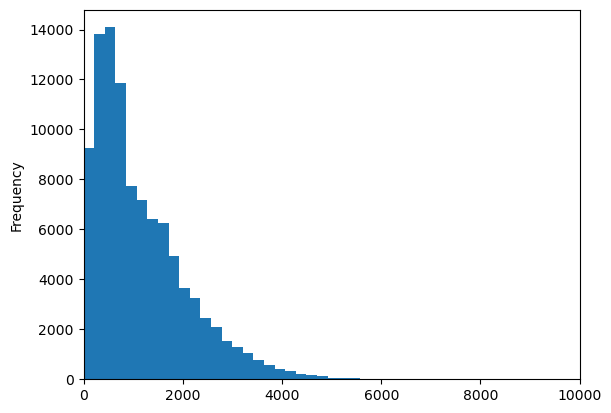

In [33]:
print(dfpd_for_graphs['trip_seconds'].describe())
print(dfpd_for_graphs['trip_seconds'].quantile(0.99))
print(dfpd_for_graphs['trip_seconds'].quantile(0.025))

dfpd_for_graphs['trip_seconds'].plot.hist(bins=400)#, range =(0.0, trip_seconds['trip_seconds'].quantile(0.975)))
plt.xlim(0.0, 10000)#trip_seconds.quantile(0.99))
plt.show()

In [34]:
trip_seconds_quant = dfsp.approxQuantile("trip_seconds", [0.025, 0.99], 0.005)
print(trip_seconds_quant)

[3.0, 4190.0]


count    100000.000000
mean          6.298316
std           7.789928
min           0.000000
25%           0.890000
50%           2.700000
75%          11.330000
max         692.300000
Name: trip_miles, dtype: float64
26.2
0.0


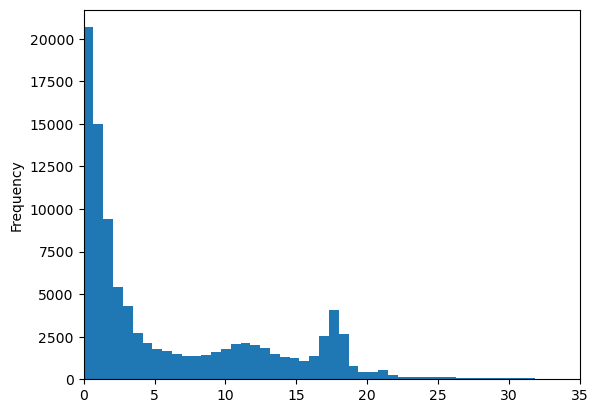

In [35]:
print(dfpd_for_graphs['trip_miles'].describe())
print(dfpd_for_graphs['trip_miles'].quantile(0.99))
print(dfpd_for_graphs['trip_miles'].quantile(0.1))

dfpd_for_graphs['trip_miles'].plot.hist(bins=1000)
plt.xlim(0.0, 35)#trip_miles['trip_miles'].quantile(0.99))

plt.show()

In [36]:
trip_miles_quant = dfsp.approxQuantile("trip_miles", [0.025, 0.99], 0.005)
print(trip_miles_quant)

[0.0, 24.7]


count    99927.000000
mean        27.071828
std         45.468084
min          0.000000
25%         10.000000
50%         17.250000
75%         41.500000
max       8004.750000
Name: trip_total, dtype: float64
98.0
6.5


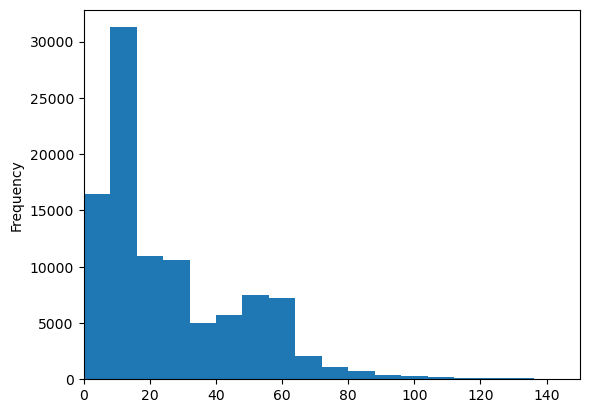

In [37]:
print(dfpd_for_graphs['trip_total'].describe())
print(dfpd_for_graphs['trip_total'].quantile(0.99))
print(dfpd_for_graphs['trip_total'].quantile(0.1))

dfpd_for_graphs['trip_total'].plot.hist(bins=1000)
plt.xlim(0.0, 150)#trip_total['trip_total'].quantile(0.99))
plt.show()

In [38]:
trip_total_quant = dfsp.approxQuantile("trip_total", [0.025, 0.99], 0.005)
print(trip_total_quant)

[3.25, 91.75]


In [39]:
dfsp.filter((dfsp.trip_seconds > trip_seconds_quant[1]) \
                    |(dfsp.trip_miles > trip_miles_quant[1]) \
                     |(dfsp.trip_total > trip_total_quant[1])
                    ).count()

284995

    Квантили не выглядят выбросами. Поездка может длиться 4000 секунд, 23 мили и стоить 100 долларов.
    Похоже, что квантили, даже 99% не отражают выбросы.
    На этом этапе отсечем данные по квантилям, чтобы улучшить обучение моделей.

In [40]:
dfsp_contracted = dfsp.filter((dfsp.trip_seconds <= trip_seconds_quant[1]) \
                    |(dfsp.trip_miles <= trip_miles_quant[1]) \
                     |(dfsp.trip_total <= trip_total_quant[1])
                    )
dfsp_contracted.count()

10155189

In [41]:
mem_use()

Количество используемой памяти 35_449_156 байт, пиковое 64_550_889 байт


    После удаления того, что принято за выбросы, осталось 9,48 млн данных - около 90%.
    Часть данных можно сохранить проведя более детальный разбор выбросов.

## Обработаем данные о времени: изменим формат на Timestamp и округлим до часа

In [43]:
#Timestamp String to DateType
dfsp_timed = dfsp_contracted \
    .withColumn("trip_end_timestamp", F.date_trunc("hour", to_timestamp("trip_end_timestamp", "MM/dd/yyyy hh:mm:ss a"))) \
    .withColumn("trip_start_timestamp", F.date_trunc("hour", to_timestamp("trip_start_timestamp", "MM/dd/yyyy hh:mm:ss a"))) 
dfsp_timed.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: long (nullable = true)
 |-- dropoff_census_tract: long (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_centroid_latitude: double (nullable = true)
 |-- pickup_centroid_longitude: double (nullable = true)
 |-- pickup_centroid_location: string (nullable = true)
 |-- dropoff_centroid_latitude: double (nullable = true)
 |-- dropoff_cen

In [44]:
dfsp_timed.sort(dfsp_timed.trip_start_timestamp.desc()).select('trip_start_timestamp', 'trip_end_timestamp').show(5)
dfsp_timed.filter((dfsp_timed["trip_start_timestamp"] > '2023-06-01 00:00:00') &
            (dfsp_timed["trip_start_timestamp"] < '2023-07-01 00:00:00')).select(
                    'trip_id', 'trip_start_timestamp', 'trip_end_timestamp').show(10, False)

+--------------------+-------------------+
|trip_start_timestamp| trip_end_timestamp|
+--------------------+-------------------+
| 2023-07-31 22:00:00|2023-07-31 22:00:00|
| 2023-07-31 22:00:00|2023-07-31 22:00:00|
| 2023-07-31 22:00:00|2023-07-31 22:00:00|
| 2023-07-31 22:00:00|2023-07-31 22:00:00|
| 2023-07-31 22:00:00|2023-07-31 22:00:00|
+--------------------+-------------------+
only showing top 5 rows

+----------------------------------------+--------------------+-------------------+
|trip_id                                 |trip_start_timestamp|trip_end_timestamp |
+----------------------------------------+--------------------+-------------------+
|015fc6b1f3e7b70b9d5fb41bb9b8c7e9e8d8ef07|2023-06-01 01:00:00 |2023-06-01 01:00:00|
|06fff25f2374b62e84f89f8917765492ad220729|2023-06-01 01:00:00 |2023-06-01 01:00:00|
|0a4d1da869df7f05b2cbf218b0bc45fd7629f680|2023-06-01 01:00:00 |2023-06-01 01:00:00|
|0ce5dff255319a32e47a7438beb84f685a55213f|2023-06-01 01:00:00 |2023-06-01 01:00:00|


## Построим карту точек подбора пассажиров с цветами по длительности поездки и расстоянию.

In [45]:
dfsp_timed.filter("trip_miles ==0.0").select(
    'trip_total', 'fare', 'trip_miles', 'trip_seconds').groupby('trip_miles').mean().show()

+----------+------------------+------------------+---------------+-----------------+
|trip_miles|   avg(trip_total)|         avg(fare)|avg(trip_miles)|avg(trip_seconds)|
+----------+------------------+------------------+---------------+-----------------+
|       0.0|20.295097263126536|15.741441647138245|            0.0|569.1104715200928|
+----------+------------------+------------------+---------------+-----------------+



In [46]:
for_feature = dfsp_timed.orderBy(rand()).limit(10**5).select('pickup_centroid_latitude', 'pickup_centroid_longitude',
                                  'trip_total', 'trip_seconds', 'trip_miles', 'fare'
                                    ).toPandas()

In [47]:
dfpd_for_graphs.info()
dfpd_for_graphs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   pickup_centroid_latitude   93314 non-null   float64
 1   pickup_centroid_longitude  93314 non-null   float64
 2   trip_total                 99927 non-null   float64
 3   trip_seconds               99987 non-null   float64
 4   trip_miles                 100000 non-null  float64
 5   fare                       99927 non-null   float64
dtypes: float64(6)
memory usage: 4.6 MB


,pickup_centroid_latitude,pickup_centroid_longitude,trip_total,trip_seconds,trip_miles,fare
0,41.874005,-87.663518,26.25,1357.0,9.30,26.25
1,41.899602,-87.633308,30.25,2002.0,10.83,30.25
2,41.899602,-87.633308,5.50,233.0,0.80,5.50
3,41.794090,-87.592311,19.50,600.0,5.80,16.50
4,41.980264,-87.913625,51.75,1860.0,0.80,41.75


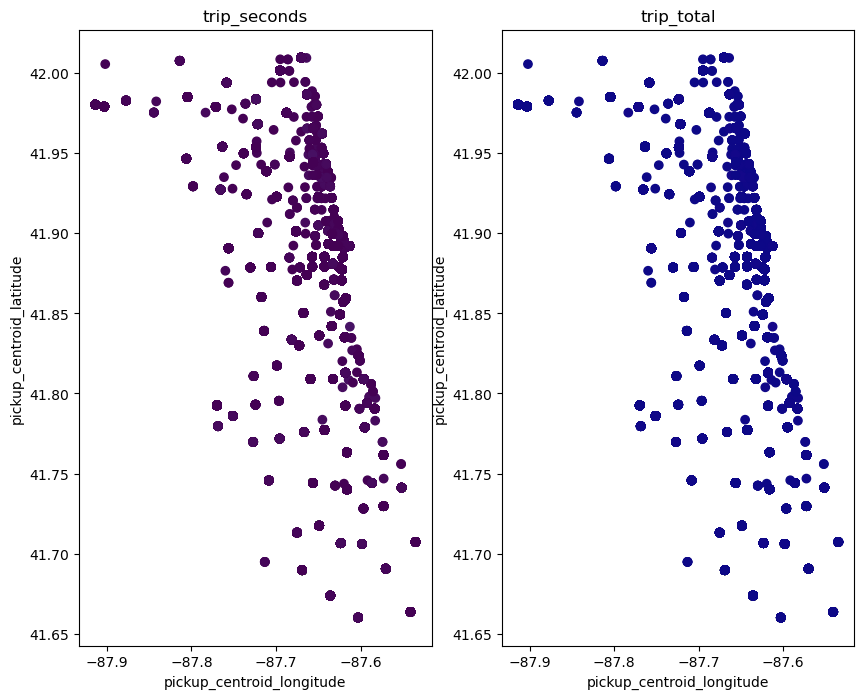

In [48]:
x = for_feature['pickup_centroid_longitude']
y = for_feature['pickup_centroid_latitude']
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(x, y, c=dfpd_for_graphs['trip_miles'], cmap='viridis')
ax2.scatter(x, y, c=dfpd_for_graphs['trip_total'], cmap='plasma')
fig.set_size_inches(10, 8)
ax1.set_title('trip_seconds')
ax1.set_xlabel('pickup_centroid_longitude')
ax1.set_ylabel('pickup_centroid_latitude')
ax2.set_title('trip_total')
ax2.set_xlabel('pickup_centroid_longitude')
ax2.set_ylabel('pickup_centroid_latitude')
plt.show()

## Пока удалим колонки, которые предположительно не будут влиять на целевой показатель. Если модели не будут набирать достаточной точности, рассмотрим их возврат

In [49]:
dfsp_timed = dfsp_timed.drop('pickup_census_tract', 'pickup_centroid_location', 
                 'tips', 'tolls', 'extras', 
                 "fare", 'company', 'payment_type', 
                 'dropoff_census_tract', 'dropoff_centroid_latitude', 
                'dropoff_centroid_longitude', 'dropoff_centroid__location')
dfsp_timed.show(5)
dfsp_timed.select('pickup_community_area').distinct().count()

+--------------------+--------------------+--------------------+-------------------+------------+----------+---------------------+----------------------+----------+------------------------+-------------------------+
|             trip_id|             taxi_id|trip_start_timestamp| trip_end_timestamp|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area|trip_total|pickup_centroid_latitude|pickup_centroid_longitude|
+--------------------+--------------------+--------------------+-------------------+------------+----------+---------------------+----------------------+----------+------------------------+-------------------------+
|bcfa19f2539021c05...|368ce5511598af2cc...| 2022-01-01 00:00:00|2022-01-01 00:00:00|         152|       0.1|                    0|                  null|      3.75|                    null|                     null|
|2aba69ff015f9ea8e...|449fa490955275713...| 2022-01-01 00:00:00|2022-01-01 00:00:00|        2360|     17.44|                    0|      

78

## Проведем агрегацию данных по часу и коммьюнити, далее в этот набор данных будем добавлять признаки

In [50]:
dfsp_timed_agg = dfsp_timed.groupby('pickup_community_area', "trip_start_timestamp").agg(
    count('trip_id').alias('trips_count'), 
    median("trip_total").alias('cost_median'), 
    median('trip_miles').alias('miles_median'),
    median("trip_seconds").alias('seconds_median'),
    median("pickup_centroid_latitude").alias('centroid_lat_median'),
    median("pickup_centroid_longitude").alias('centroid_long_median'),
    countDistinct('taxi_id').alias('taxi_countdist')
).cache()
#dfsp_timed_agg.printSchema()

In [52]:
dfsp_timed_agg.sort('trip_start_timestamp').show(5)

+---------------------+--------------------+-----------+------------------+------------------+--------------+-------------------+--------------------+--------------+
|pickup_community_area|trip_start_timestamp|trips_count|       cost_median|      miles_median|seconds_median|centroid_lat_median|centroid_long_median|taxi_countdist|
+---------------------+--------------------+-----------+------------------+------------------+--------------+-------------------+--------------------+--------------+
|                   21| 2022-01-01 00:00:00|          2|10.495000000000001|               0.0|         727.0|       41.938666196|       -87.711210593|             2|
|                   76| 2022-01-01 00:00:00|         24|             40.25|             12.64|        1372.5|       41.980264315|       -87.913624596|            22|
|                    6| 2022-01-01 00:00:00|         32|14.440000000000001|              2.69|         691.0|       41.944226601|       -87.655998182|            25|
|   

    В итоге, наш целевой показатель - trips_count

    Потерялись часы, где не было поездок в районе.

## Восполним утерянные часы

In [53]:
max_hour = '2023-07-31 23:00:00'#max(dfsp_timed.trip_start_timestamp) 
min_hour = '2022-01-01 00:00:00' #min(dfsp_timed.trip_start_timestamp)# 

In [54]:
hours = spark.createDataFrame([(min_hour, max_hour)], ["min_hour", "max_hour"])
hours = hours.selectExpr("explode(sequence(to_timestamp(min_hour), to_timestamp(max_hour), interval 1 hour)) as time") 

hours=hours.select(F.date_trunc('hour', hours.time).alias("hour_cons")).cache()

In [55]:
hours.sort(hours.hour_cons.desc()).show(5)
hours.show(5)
hours.count()

+-------------------+
|          hour_cons|
+-------------------+
|2023-07-31 23:00:00|
|2023-07-31 22:00:00|
|2023-07-31 21:00:00|
|2023-07-31 20:00:00|
|2023-07-31 19:00:00|
+-------------------+
only showing top 5 rows

+-------------------+
|          hour_cons|
+-------------------+
|2022-01-01 00:00:00|
|2022-01-01 01:00:00|
|2022-01-01 02:00:00|
|2022-01-01 03:00:00|
|2022-01-01 04:00:00|
+-------------------+
only showing top 5 rows



13848

In [56]:
allhours_schema = StructType([ \
                                StructField("hour_cons",TimestampType(),True), \
                                StructField("pickup_community_area",IntegerType (),True) \
                              ])
all_hours = spark.createDataFrame([], allhours_schema)
for i in range(78):
    temp = hours.withColumn('pickup_community_area', lit(i))
    all_hours = all_hours.union(temp)

In [57]:
all_hours.show(5)
all_hours.filter('pickup_community_area==77').sort(all_hours.hour_cons.desc()).show(5)
all_hours.count()

+-------------------+---------------------+
|          hour_cons|pickup_community_area|
+-------------------+---------------------+
|2022-01-01 00:00:00|                    0|
|2022-01-01 01:00:00|                    0|
|2022-01-01 02:00:00|                    0|
|2022-01-01 03:00:00|                    0|
|2022-01-01 04:00:00|                    0|
+-------------------+---------------------+
only showing top 5 rows

+-------------------+---------------------+
|          hour_cons|pickup_community_area|
+-------------------+---------------------+
|2023-07-31 23:00:00|                   77|
|2023-07-31 22:00:00|                   77|
|2023-07-31 21:00:00|                   77|
|2023-07-31 20:00:00|                   77|
|2023-07-31 19:00:00|                   77|
+-------------------+---------------------+
only showing top 5 rows



1080144

## Закинем в ДФ со всеми районами и часами агрегированные данные

In [58]:
all_hours = all_hours \
    .join(dfsp_timed_agg, (all_hours.hour_cons == dfsp_timed_agg.trip_start_timestamp) &
    (all_hours.pickup_community_area == dfsp_timed_agg.pickup_community_area), 'left_outer').select(
    all_hours.pickup_community_area,
    all_hours.hour_cons,
    dfsp_timed_agg.taxi_countdist,
    dfsp_timed_agg.trips_count,
    dfsp_timed_agg.cost_median,
    dfsp_timed_agg.miles_median,
    dfsp_timed_agg.seconds_median,
    dfsp_timed_agg.taxi_countdist
    ).na.fill(value=0).cache()

#all_hours = all_hours.na.fill(value=0)
#all_hours.filter(all_hours.pickup_community_area==rand_community).sort(all_hours.hour_cons.desc()).show(30)
#all_hours.filter(all_hours.pickup_community_area==rand_community).count()

In [59]:
dfsp_timed_agg.filter(dfsp_timed.pickup_community_area==rand_community).sort(dfsp_timed.trip_start_timestamp.desc()).show(30)

+---------------------+--------------------+-----------+-----------+------------------+--------------+-------------------+--------------------+--------------+
|pickup_community_area|trip_start_timestamp|trips_count|cost_median|      miles_median|seconds_median|centroid_lat_median|centroid_long_median|taxi_countdist|
+---------------------+--------------------+-----------+-----------+------------------+--------------+-------------------+--------------------+--------------+
|                   69| 2023-07-31 20:00:00|          3|      25.25|               4.6|         660.0|       41.763246799|       -87.616134111|             3|
|                   69| 2023-07-31 19:00:00|          4|     31.625|              7.66|        1242.5|       41.763246799|       -87.616134111|             4|
|                   69| 2023-07-31 18:00:00|          7|      28.25|               0.2|        1620.0|       41.763246799|       -87.616134111|             7|
|                   69| 2023-07-31 17:00:00|  

In [60]:
mem_use()

Количество используемой памяти 33_025_492 байт, пиковое 71_242_388 байт


In [61]:
all_hours.explain()

== Physical Plan ==
InMemoryTableScan [pickup_community_area#20845, hour_cons#19924, taxi_countdist#20846L, trips_count#20847L, cost_median#20848, miles_median#20849, seconds_median#20850, taxi_countdist#20851L]
   +- InMemoryRelation [pickup_community_area#20845, hour_cons#19924, taxi_countdist#20846L, trips_count#20847L, cost_median#20848, miles_median#20849, seconds_median#20850, taxi_countdist#20851L], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(82) Project [coalesce(pickup_community_area#19925, 0) AS pickup_community_area#20845, hour_cons#19924, coalesce(taxi_countdist#18934L, 0) AS taxi_countdist#20846L, coalesce(trips_count#18923L, 0) AS trips_count#20847L, coalesce(nanvl(cost_median#18925, null), 0.0) AS cost_median#20848, coalesce(nanvl(miles_median#18927, null), 0.0) AS miles_median#20849, coalesce(nanvl(seconds_median#18929, null), 0.0) AS seconds_median#20850, coalesce(taxi_countdist#18934L, 0) AS taxi_countdist#20851L]
            +- *(82) SortMergeJ

In [62]:
all_hours.toPandas().to_csv('all_hours.csv')
#all_hours.repartition(1).write.mode('overwrite').csv("all_hours")

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


### Итог первого этапа
    составили сгруппированные данные по району и времени. 
    Восстановили полную временную шкалу.
    Выделили целевой признак trips_count
    промежуточный датасэт -  all_hours